The goal of this notebook is to test the GP with the Gaussian conditional likelihood assumption.

In [1]:
import importlib
import itertools
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

np.random.seed(33333)
torch.manual_seed(33333)
%matplotlib inline

In [2]:
import razor_data
import toy_data
import plotting
import gp
importlib.reload(razor_data);
importlib.reload(toy_data);
importlib.reload(plotting);

### Squared exponential kernel

In [3]:
debug = True

# data
num_mr_bins = 50
mr_max = 1200
binned_data = razor_data.get_binned_data_1d(
    num_mr_bins=num_mr_bins, mr_max=mr_max)
test_data = binned_data['MultiJet'][1]
U = test_data['u']
Y = test_data['y']

# model
test_ell = 100
test_alpha = 2000
test_kernel = gp.SquaredExponentialKernel(test_ell, test_alpha)
G = gp.GaussianLikelihoodGP(test_kernel, U, Y)

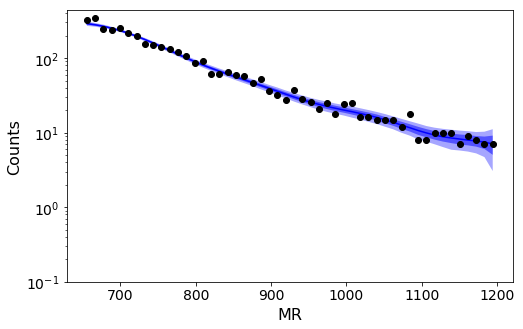

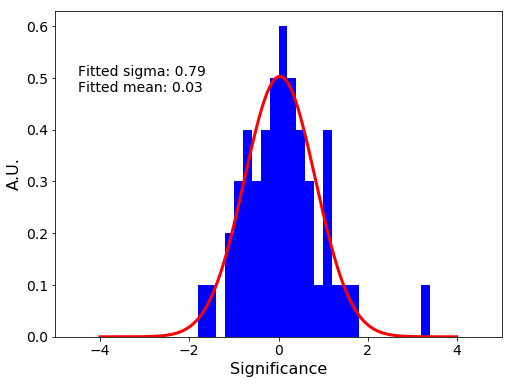

In [4]:
# plot for fixed initial kernel parameters
plotting.plot_hist_1d(test_data, G=G)
plotting.plot_nsigma_1d(test_data, G, use_poisson_noise=True)

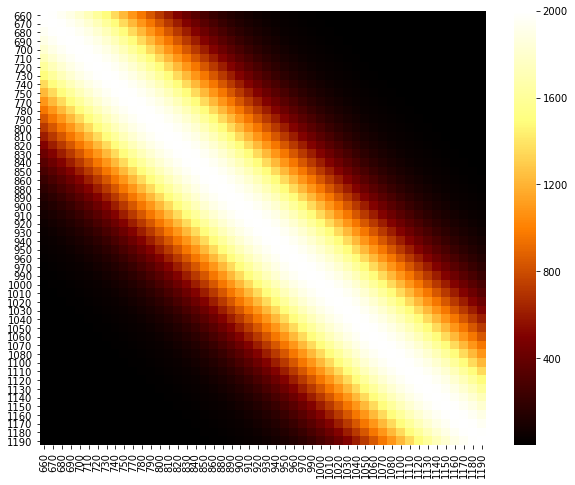

In [8]:
plotting.plot_covariance(G)

In [5]:
# model
test_ell = 100
test_alpha = 1
test_kernel = gp.SquaredExponentialKernel(test_ell, test_alpha)
G = gp.GaussianLikelihoodGP(test_kernel, U, Y)
        
optim = torch.optim.LBFGS(G.parameters(), lr=0.01)
def closure():
    optim.zero_grad()
    G.clear()
    nlogp = G.neg_log_p()
    nlogp.backward()
    return nlogp
for i in range(50):
    optim.zero_grad()
    G.clear()
    nlogp = G.neg_log_p()
    nlogp.backward()
    optim.step(closure)
    print("{}: {:.2f} {:.2f}".format(i,
            G.kernel.log_ell.exp().data.numpy()[0],
            G.kernel.log_alpha.exp().data.numpy()[0]))
G.clear()

0: 310.10 120.92
1: 274.59 201.46
2: 238.00 307.58
3: 222.69 427.50
4: 210.49 591.81
5: 197.27 796.02
6: 190.43 1054.99
7: 187.42 1388.91
8: 186.04 1815.93
9: 185.47 2357.81
10: 185.47 3041.91
11: 186.05 3903.68
12: 187.31 4988.06
13: 189.35 6352.65
14: 192.17 8067.08
15: 195.73 10209.06
16: 199.98 12880.31
17: 204.68 16169.00
18: 209.91 20186.48
19: 215.82 25137.60
20: 221.93 31000.62
21: 228.43 38153.31
22: 235.44 46832.14
23: 242.53 57511.30
24: 264.23 99027.02
25: 264.06 100363.88
26: 262.85 101177.77
27: 262.65 101226.41
28: 262.11 101345.32
29: 261.98 101376.93
30: 261.56 101466.30
31: 261.55 101468.72
32: 261.53 101475.30
33: 261.53 101475.50
34: 261.53 101475.50
35: 261.53 101475.50
36: 261.53 101475.50
37: 261.53 101475.50
38: 261.53 101475.50
39: 261.53 101475.50
40: 261.53 101475.50
41: 261.53 101475.50
42: 261.53 101475.50
43: 261.53 101475.50
44: 261.53 101475.50
45: 261.53 101475.50
46: 261.53 101475.50
47: 261.53 101475.50
48: 261.53 101475.50
49: 261.53 101475.50


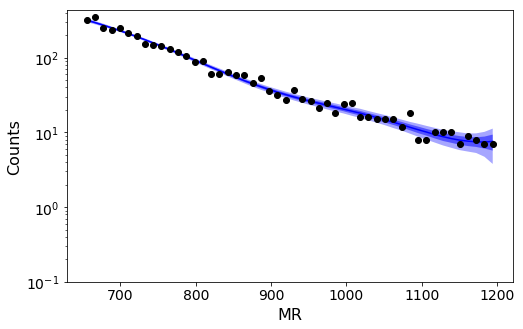

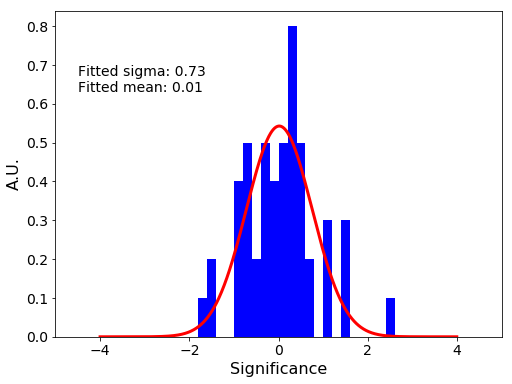

In [136]:
plotting.plot_hist_1d(test_data, G=G)
plotting.plot_nsigma_1d(test_data, G, use_poisson_noise=True)

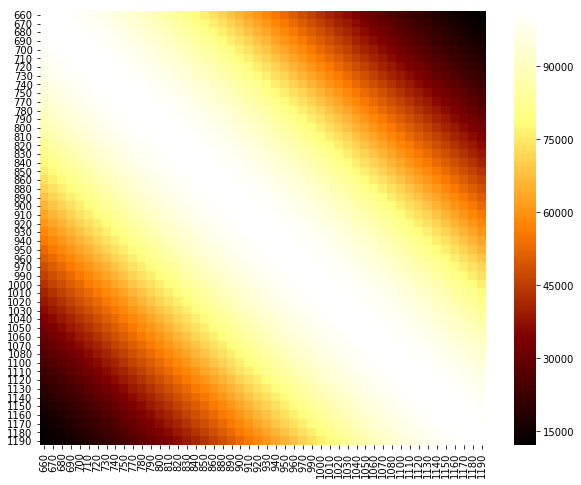

In [133]:
plotting.plot_covariance(G)

It works okay for the initial choice of hyperparameters.  But the best-fit covariance strength seems way too large.  Guesses:

1) maybe the gradient calculation is numerically unstable; we are doing backprop through a Cholesky decomposition and a matrix inverse.

2) maybe the kernel is not appropriate for this case -- it assumes a constant covariance strength, but our function ranges over many orders of magnitude so it would be better if the typical fluctuation size changed with MR.

First I will test (1) by comparing the log likelihood values and their gradients with other GP implementations.

Second I will test (2) by implementing the 'physics-aware' kernel in the Frate et al. paper, which has a covariance strength that is exponentially decreasing.

### Sanity check with scikit-learn

In [41]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

In [44]:
# data
num_mr_bins = 50
mr_max = 1200
binned_data = razor_data.get_binned_data_1d(
    num_mr_bins=num_mr_bins, mr_max=mr_max)
test_data = binned_data['MultiJet'][1]
U = test_data['u']
Y = test_data['y']

U_sk = U.unsqueeze(1).numpy()
ell = 40.
alpha = 300.
noise = 10
sk_kernel = RBF(length_scale=ell) * C(constant_value=alpha)
sk_gp = GaussianProcessRegressor(kernel=sk_kernel, alpha=noise,
                                n_restarts_optimizer=10)
sk_gp.fit(U_sk, Y.numpy())
print("sk_gp:", sk_gp.log_marginal_likelihood(
    theta=[np.log(ell), np.log(alpha)])) #sk stores these in log form

test_kernel = gp.SquaredExponentialKernel(ell, alpha)
G = gp.GaussianLikelihoodGP(test_kernel, U, Y, sigma2=noise)
print("my_gp:", -G.neg_log_p().data.numpy()[0])

sk_gp: -594.560867767
my_gp: -594.56


It matches.  

In [45]:
np.exp(sk_gp.kernel_.theta)

array([   16.7900612 ,  8033.79383576])

The scikit-learn fit routine ended up with a correlation length of order the bin size.  

In [47]:
sk_grad = sk_gp.log_marginal_likelihood(
    theta=[np.log(ell), np.log(alpha)], eval_gradient=True)[1]
print("SK grad with resp to each parameter: {:.3f} {:.3f}".format(
    sk_grad[0], sk_grad[1]))

sgd = torch.optim.SGD(G.parameters(), lr=0.1)
sgd.zero_grad()
G.clear()
nlogp = G.neg_log_p()
nlogp.backward()
print("My grad with resp to each parameter: {:.3f} {:.3f}".format(
    G.kernel.log_ell.grad.data.numpy()[0],
    G.kernel.log_alpha.grad.data.numpy()[0]
))

SK grad with resp to each parameter: 9.921 211.856
My grad with resp to each parameter: -9.922 -211.856


The sign difference is because I am computing negative log marginal likelihood. 

Everything seems to check out.

### Fit the log of the count data

In [6]:
debug = False

# data
num_mr_bins = 50
mr_max = 1200
binned_data = razor_data.get_binned_data_1d(
    num_mr_bins=num_mr_bins, mr_max=mr_max)
test_data = binned_data['MultiJet'][1]
test_data['y'] = test_data['y'].log()
U = test_data['u']
Y = test_data['y']

# model
test_ell = 100
test_alpha = 10
test_sigma2 = 10
test_kernel = gp.SquaredExponentialKernel(test_ell, test_alpha)
G = gp.GaussianLikelihoodGP(test_kernel, U, Y, sigma2=test_sigma2)

optim = torch.optim.LBFGS(G.kernel.parameters(), lr=0.01)
def closure():
    optim.zero_grad()
    G.clear()
    nlogp = G.neg_log_p()
    nlogp.backward()
    return nlogp
for i in range(2500):
    optim.zero_grad()
    G.clear()
    nlogp = G.neg_log_p()
    nlogp.backward()
    optim.step(closure)
    if debug:
        print("{}: {:.2f} {:.2f} {:.2f}".format(i, 
            test_kernel.log_ell.exp().data.numpy()[0], 
            test_kernel.log_alpha.exp().data.numpy()[0],
            G.log_sigma2.exp().data.numpy()[0],
                                        ))
G.clear()

In [7]:
print(G.kernel.log_ell.exp().data.numpy()[0])
print(G.kernel.log_alpha.exp().data.numpy()[0])

707.733
17.4078


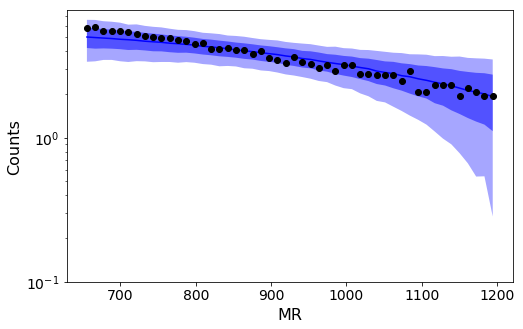

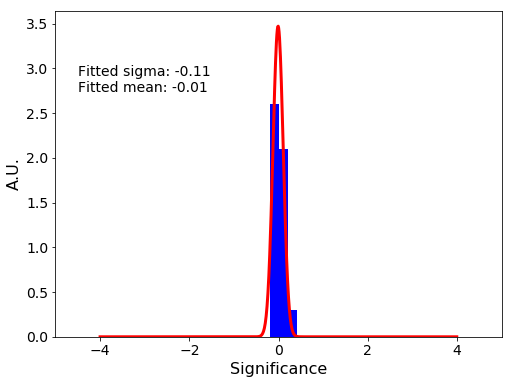

In [144]:
plotting.plot_hist_1d(test_data, G=G)
plotting.plot_nsigma_1d(test_data, G)

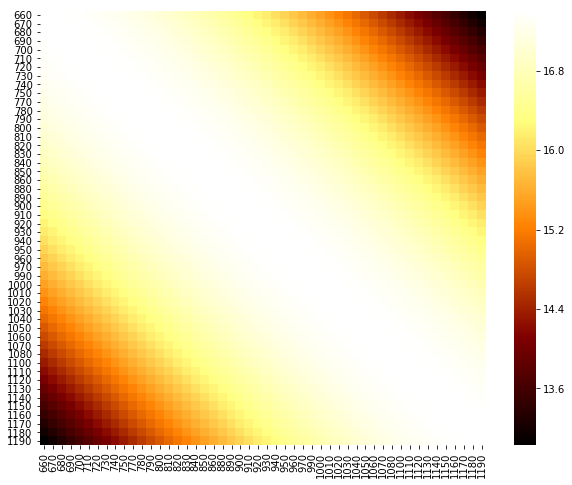

In [145]:
plotting.plot_covariance(G)

In [146]:
# check against sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# data
num_mr_bins = 50
mr_max = 1200
binned_data = razor_data.get_binned_data_1d(
    num_mr_bins=num_mr_bins, mr_max=mr_max)
test_data = binned_data['MultiJet'][1]
U = test_data['u']
Y = test_data['y'].log()

U_sk = U.unsqueeze(1).numpy()
ell = 40.
alpha = 300.
noise = 10
sk_kernel = RBF(length_scale=ell) * C(constant_value=alpha)
sk_gp = GaussianProcessRegressor(kernel=sk_kernel, alpha=noise)
sk_gp.fit(U_sk, Y.numpy())
np.exp(sk_gp.kernel_.theta)

array([ 707.75120738,   17.40807318])

The result agrees with scikit-learn.  The residuals are way underdispersed; this is okay because we are not fitting for the noise parameter (and the log counts are not expected to have gaussian noise anyway).

In [148]:
# do the same thing but fitting for the noise this time
debug = False

# data
num_mr_bins = 50
mr_max = 1200
binned_data = razor_data.get_binned_data_1d(
    num_mr_bins=num_mr_bins, mr_max=mr_max)
test_data = binned_data['MultiJet'][1]
test_data['y'] = test_data['y'].log()
U = test_data['u']
Y = test_data['y']

# model
test_ell = 100
test_alpha = 10
test_sigma2 = 10
test_kernel = gp.SquaredExponentialKernel(test_ell, test_alpha)
G = gp.GaussianLikelihoodGP(test_kernel, U, Y, sigma2=test_sigma2)

optim = torch.optim.LBFGS(G.parameters(), lr=0.01)
for i in range(1000):
    def closure():
        optim.zero_grad()
        G.clear()
        nlogp = G.neg_log_p()
        nlogp.backward()
        return nlogp
    optim.zero_grad()
    G.clear()
    nlogp = G.neg_log_p()
    nlogp.backward()
    optim.step(closure)
    if debug:
        print("{}: {:.2f} {:.2f} {:.2f}".format(i, 
            test_kernel.log_ell.exp().data.numpy()[0], 
            test_kernel.log_alpha.exp().data.numpy()[0],
            G.log_sigma2.exp().data.numpy()[0],
                                        ))
G.clear()

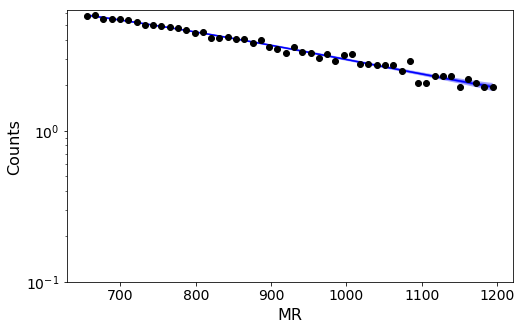

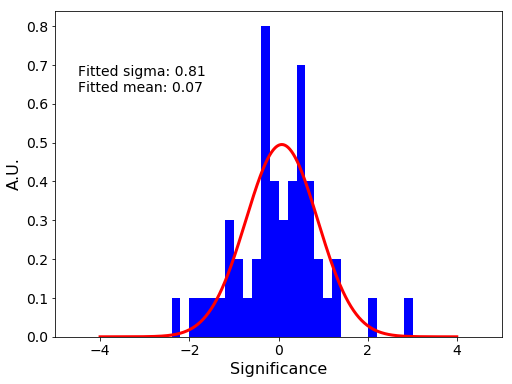

In [149]:
plotting.plot_hist_1d(test_data, G=G)
plotting.plot_nsigma_1d(test_data, G)

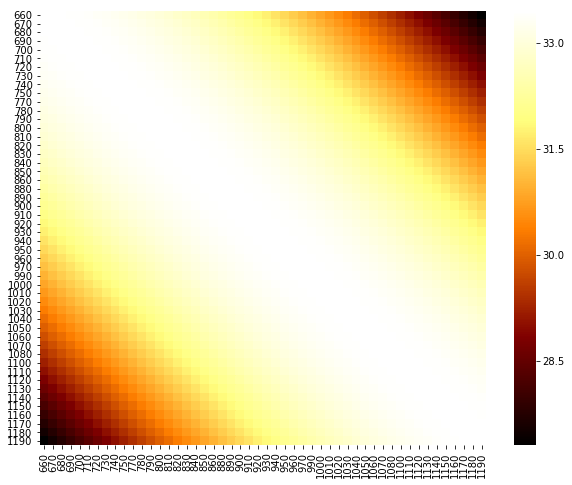

In [150]:
plotting.plot_covariance(G)

In [153]:
print(G.kernel.log_ell.exp().data.numpy()[0])
print(G.kernel.log_alpha.exp().data.numpy()[0])
print(G.log_sigma2.exp().data.numpy()[0])

845.348
33.4608
0.0205278


### Use an exponential mean function

In [154]:
debug = True

# data
num_mr_bins = 50
mr_max = 1200
binned_data = razor_data.get_binned_data_1d(
    num_mr_bins=num_mr_bins, mr_max=mr_max)
test_data = binned_data['MultiJet'][1]
U = test_data['u']
Y = test_data['y']

# model
test_ell = 100
test_alpha = 1000
test_N = 300000
test_slope = 0.03
test_mean = gp.ExponentialMean(test_N, test_slope)
test_kernel = gp.SquaredExponentialKernel(test_ell, test_alpha)
G = gp.GaussianLikelihoodGP(test_kernel, U, Y, mean=test_mean)

optim = torch.optim.LBFGS(G.parameters(), lr=0.01)
for i in range(25):
    def closure():
        optim.zero_grad()
        G.clear()
        nlogp = G.neg_log_p()
        nlogp.backward()
        return nlogp
    optim.zero_grad()
    G.clear()
    nlogp = G.neg_log_p()
    nlogp.backward()
    optim.step(closure)
    if debug:
        print("{}: ell={:.2f} alpha={:.2f} N={:.2f} slope={:.2f}".format(i, 
            test_kernel.log_ell.exp().data.numpy()[0], 
            test_kernel.log_alpha.exp().data.numpy()[0],
            test_mean.log_N.exp().data.numpy()[0],
            test_mean.log_slope.exp().data.numpy()[0],
                                        ))
G.clear()

0: ell=101.26 alpha=1263.72 N=300000.06 slope=0.03
1: ell=103.39 alpha=1591.80 N=299997.47 slope=0.03
2: ell=106.21 alpha=1997.42 N=299991.75 slope=0.03
3: ell=109.73 alpha=2501.13 N=299980.88 slope=0.03
4: ell=114.09 alpha=3127.72 N=299966.28 slope=0.03
5: ell=119.57 alpha=3926.80 N=299946.28 slope=0.03
6: ell=126.98 alpha=4956.94 N=299919.38 slope=0.03
7: ell=136.98 alpha=6353.02 N=299880.50 slope=0.03
8: ell=149.11 alpha=8288.47 N=299826.44 slope=0.03
9: ell=161.94 alpha=10885.36 N=299755.81 slope=0.03
10: ell=173.37 alpha=14154.19 N=299674.38 slope=0.03
11: ell=183.68 alpha=18091.70 N=299589.78 slope=0.03
12: ell=193.29 alpha=22879.19 N=299498.94 slope=0.03
13: ell=202.46 alpha=28624.80 N=299407.25 slope=0.03
14: ell=211.40 alpha=35558.90 N=299317.06 slope=0.03
15: ell=220.86 alpha=44326.67 N=299221.44 slope=0.03
16: ell=231.51 alpha=56032.77 N=299113.59 slope=0.03
17: ell=245.88 alpha=75573.18 N=298971.28 slope=0.03
18: ell=256.32 alpha=93180.09 N=298870.66 slope=0.03
19: ell=255.

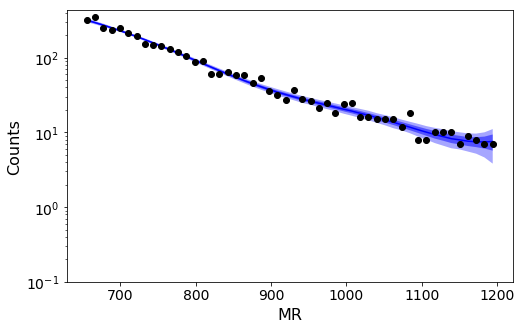

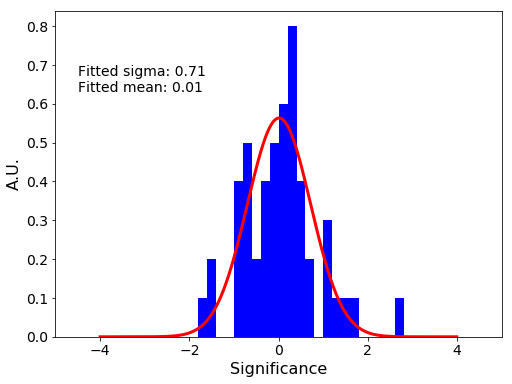

In [155]:
plotting.plot_hist_1d(test_data, G=G)
plotting.plot_nsigma_1d(test_data, G, use_poisson_noise=True)

The best-fit covariance is still very large.

### Physics-aware kernel

In [23]:
debug = False

# data
num_mr_bins = 50
mr_max = 1200
binned_data = razor_data.get_binned_data_1d(
    num_mr_bins=num_mr_bins, mr_max=mr_max)
test_data = binned_data['MultiJet'][1]
U = test_data['u']
Y = test_data['y']

# model
test_a = 0.01
test_b = 1
test_c = 300
test_A = 100
test_kernel = gp.PhysicsInspiredKernel(
    test_A, test_a, test_b, test_c)
G = gp.GaussianLikelihoodGP(test_kernel, U, Y)

optim = torch.optim.LBFGS(G.parameters(), lr=0.01)
for i in range(400):
    def closure():
        optim.zero_grad()
        G.clear()
        nlogp = G.neg_log_p()
        nlogp.backward()
        return nlogp
    optim.zero_grad()
    G.clear()
    nlogp = G.neg_log_p()
    nlogp.backward()
    optim.step(closure)
    if debug:
        print("{}: A={:.2f} a={:.2f} b={:.2f} c={:.2f}".format(i, 
            test_kernel.log_A.exp().data.numpy()[0],
            test_kernel.log_a.exp().data.numpy()[0],
            test_kernel.log_b.exp().data.numpy()[0],
            test_kernel.log_c.exp().data.numpy()[0],
                                        ))
G.clear()

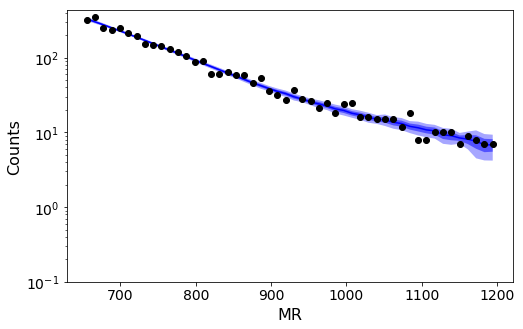

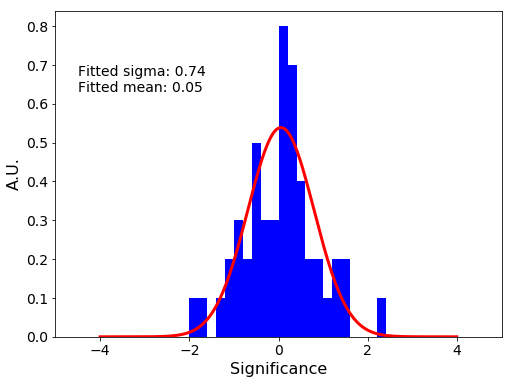

In [24]:
plotting.plot_hist_1d(test_data, G=G)
plotting.plot_nsigma_1d(test_data, G, use_poisson_noise=True)

In [25]:
print(G.kernel.log_A.exp().data.numpy()[0])
print(G.kernel.log_a.exp().data.numpy()[0])
print(G.kernel.log_b.exp().data.numpy()[0])
print(G.kernel.log_c.exp().data.numpy()[0])

3.91161e+06
9.79972e-08
1.3172
15.5389


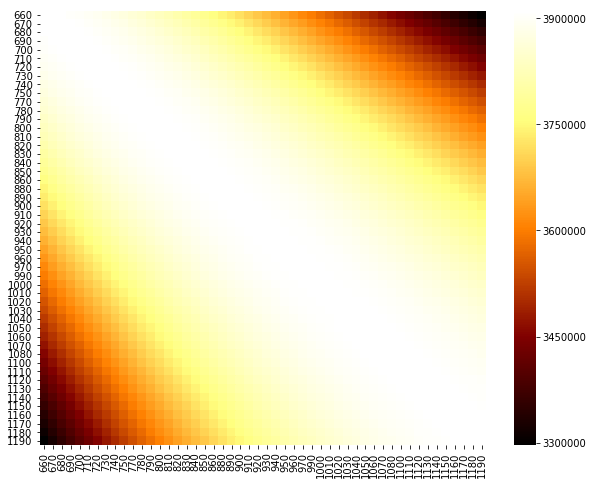

In [30]:
plotting.plot_covariance(G)

The covariance is completely dominated by the huge constant covariance strength A.

### Toy data test

In [31]:
# first check pre-fit
debug = True

# data
true_N = 300000
true_slope = 0.01
true_sigma2 = 100
num_mr_bins = 50
mr_min = 650
mr_max = 1200
test_data = toy_data.gen_exponential_toy(
    true_N, true_slope, true_sigma2,
    num_mr_bins, mr_min, mr_max)
U = test_data['u']
Y = test_data['y']

# model
test_ell = 100
test_alpha = 0.001
test_sigma2 = 100
test_N = 300000
test_slope = 0.01
test_mean = gp.ExponentialMean(test_N, test_slope)
test_kernel = gp.SquaredExponentialKernel(test_ell, test_alpha)
G = gp.GaussianLikelihoodGP(test_kernel, U, Y, 
                            sigma2=test_sigma2, mean=test_mean)

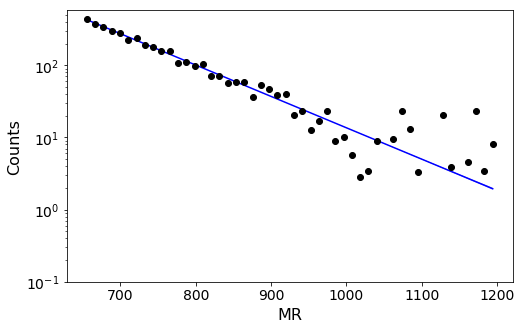

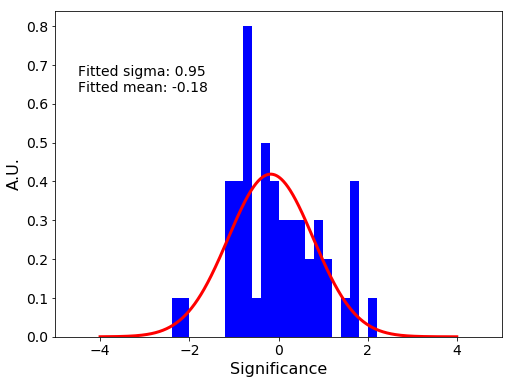

In [32]:
# look at results without fitting
plotting.plot_hist_1d(test_data, G=G)
plotting.plot_nsigma_1d(test_data, G)

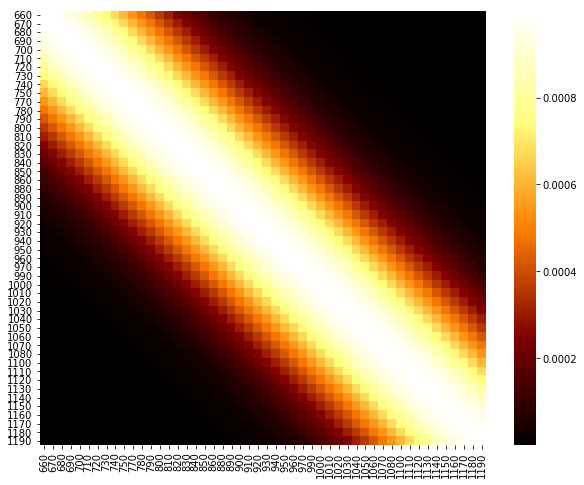

In [187]:
plotting.plot_covariance(G)

In [35]:
# Fit a constant function with noise
debug = False

# data
true_N = 3000
true_slope = 0
true_sigma2 = 2000
num_mr_bins = 50
mr_min = 650
mr_max = 1200
test_data = toy_data.gen_exponential_toy(
    true_N, true_slope, true_sigma2,
    num_mr_bins, mr_min, mr_max)
U = test_data['u']
Y = test_data['y']

# model
test_ell = 100
test_alpha = 10
test_sigma2 = 100
test_kernel = gp.SquaredExponentialKernel(test_ell, test_alpha)
G = gp.GaussianLikelihoodGP(test_kernel, U, Y, 
                            sigma2=test_sigma2)

optim = torch.optim.LBFGS(G.parameters(), lr=0.01)
for i in range(1000):
    def closure():
        optim.zero_grad()
        G.clear()
        nlogp = G.neg_log_p()
        nlogp.backward()
        return nlogp
    optim.zero_grad()
    G.clear()
    nlogp = G.neg_log_p()
    nlogp.backward()
    optim.step(closure)
    if debug:
        print("{}: ell={:.2f} alpha={:.2f} sigma2={:.2f}".format(i, 
            test_kernel.log_ell.exp().data.numpy()[0], 
            test_kernel.log_alpha.exp().data.numpy()[0],
            G.log_sigma2.exp().data.numpy()[0],
                                        ))
G.clear()

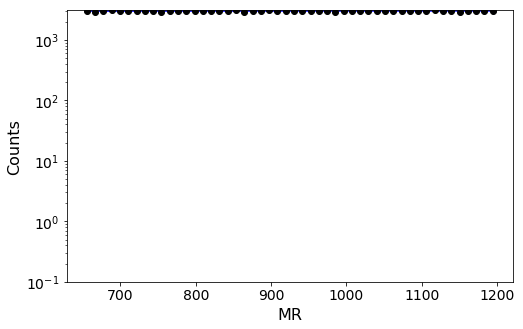

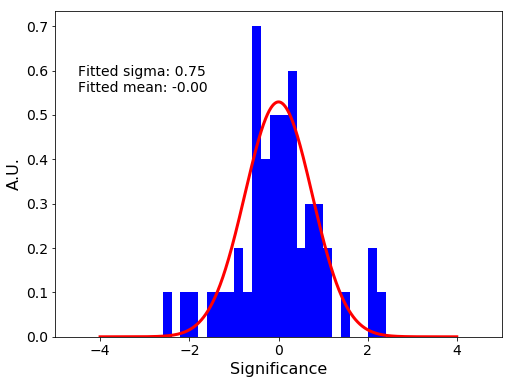

In [36]:
plotting.plot_hist_1d(test_data, G=G)
plotting.plot_nsigma_1d(test_data, G)

In [37]:
print(G.kernel.log_ell.exp().data.numpy()[0])
print(G.kernel.log_alpha.exp().data.numpy()[0])

56879.2
5.66783e+06


Fitting random noise works (though also produces extremely high correlation strength).

The conclusion for now is that the very high correlation strength is actually favored and may not be a sign of a pathology.  